In [28]:
import requests
import pandas as pd
import hmac
import hashlib
from datetime import datetime
import numpy as np

In [29]:
import credentials
secret_bytes = bytes(credentials.secret , 'latin-1')

In [30]:
rates_request = requests.get("https://api.coinbase.com/v2/exchange-rates?currency=USD")
rates = pd.DataFrame.from_dict(rates_request.json()["data"])
rates = rates[["rates"]].astype(float).rename(columns={"rates": "rate"})
rates

,rate
1INCH,1.034126
AAVE,0.008814
ACH,57.466310
ADA,1.664447
AED,3.673100
...,...
ZEN,0.045788
ZMW,17.247959
ZRX,2.412982
ZWD,463.465400


In [31]:
def generate_access_sign(timestamp, method, requestPath, body):
    message = timestamp + method + requestPath + body
    message_bytes = bytes(message , 'latin-1')
    signature = hmac.new(secret_bytes, message_bytes, digestmod = hashlib.sha256).hexdigest()
    return signature

In [32]:
def coinbase_api(path):
    BASE = "https://api.coinbase.com"
    timestamp = str(round(datetime.now().timestamp()))
    signature = generate_access_sign(timestamp, "GET", path, "")
    HEADERS = {
        "CB-ACCESS-KEY": credentials.key,
        "CB-ACCESS-SIGN": signature,
        "CB-ACCESS-TIMESTAMP": timestamp,
        "CB-VERSION": "2022-05-15"
    }
    return requests.get(BASE+path, headers=HEADERS)

wallets_request = coinbase_api("/v2/accounts?limit=300")
# display(wallets_request.json())

In [33]:
assets = pd.DataFrame.from_dict(wallets_request.json()["data"])
assets["symbol"] = assets["balance"].apply(lambda balance: balance["currency"])
assets["balance"] = assets["balance"].apply(lambda balance: float(balance["amount"]))
assets = assets[["symbol", "balance", "id"]].set_index("symbol")

In [34]:
assets = assets.join(rates)
assets["balance"] = assets["balance"] / assets["rate"]

In [35]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(assets)

In [36]:
# Tidy up coinbase data
assets.rename(index={'CGLD':'CELO'}, inplace=True)
assets.drop(index="USD", inplace=True)

In [37]:
mc_dicts = []
for page in range(1, 20):
    results = requests.get(f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page=250&page={page}&sparkline=false").json()
    mc_dicts.extend(results)

In [38]:
mc = pd.DataFrame.from_dict(mc_dicts)
mc["symbol"] = mc["symbol"].str.upper()
mc.set_index("symbol", inplace=True)
mc = mc[["market_cap"]]
mc = mc[~(mc["market_cap"] == 0)]
# mc[mc.index.duplicated()].sort_index()


In [39]:
df = assets.join(mc)

In [40]:
weights = pd.read_csv('active_weights.csv', index_col="symbol")
weights["weight"] = pd.to_numeric(weights["weight"])
df = df.join(weights)

In [41]:
# Missing market caps
df[df["market_cap"].isnull()]

,balance,id,rate,market_cap,weight
symbol,,,,,
LOOM,0.0,d1e2d5dd-c742-55e5-a60b-5d20b8658568,18.552876,NaN,NaN
PAX,0.0,PAX,1.000450,NaN,0.0


In [42]:
df = df[~df["market_cap"].isnull()]

In [43]:
# To be weighted
df[df["weight"].isnull()].sort_values("market_cap", ascending=False)[["market_cap", "weight"]]

,market_cap,weight
symbol,,


<AxesSubplot:ylabel='Frequency'>

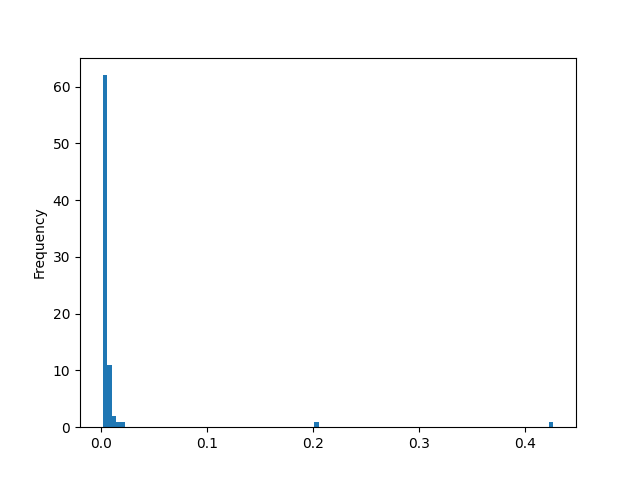

In [44]:
df = df[~df["weight"].isnull()]
df = df[~(df["weight"] == 0)]
df["custom_weighted_mc"] = df["market_cap"] * df["weight"]
df["custom_allocation_target"] = df["custom_weighted_mc"] / df["custom_weighted_mc"].sum()
df["log_custom_weighted_mc"] = np.log(df["custom_weighted_mc"])
df["log_custom_weighted_allocation_target"] = df["log_custom_weighted_mc"] / df["log_custom_weighted_mc"].sum()
log_weight = 0.3
df["fully_weighted_allocation_target"] = (df["log_custom_weighted_allocation_target"] * log_weight) + (df["custom_allocation_target"] * (1-log_weight))
%matplotlib widget
df["fully_weighted_allocation_target"].plot.hist(bins=100)

In [45]:
df["current_allocation"] = df["balance"] / df["balance"].sum()
df["target_allocation"] = df["fully_weighted_allocation_target"] * credentials.target_portfolio_size
df["delta"] = df["target_allocation"] - df["balance"]
# df[["balance", "fully_weighted_allocation_target", "target_allocation", "delta"]].sort_values("delta", ascending=False)

In [46]:

def get_latest_tx(row):
    tx_request = coinbase_api(f"/v2/accounts/{row.id}/transactions")
    # display(tx_request.content)
    
    # ridiculous coinbase doubled data problem
    transactions = pd.DataFrame.from_dict(tx_request.json()["data"])
    # doubled_content = tx_request.text
    # import json
    # transactions = pd.DataFrame.from_dict(json.loads(doubled_content[:len(doubled_content)//2])["data"])
    
    if transactions.empty:
        return row
    transactions["timestamp"] = pd.to_datetime(transactions["updated_at"])
    transactions["symbol"] = row.name
    x = transactions.groupby(by=["type", "symbol"])[["timestamp"]].agg("max")
    x = x.reset_index(level="type")
    x = x.pivot(index=None, columns="type", values="timestamp")
    row["last_bought"] = x["buy"][0] if "buy" in x.columns else None
    row["last_sold"] = x["sell"][0] if "sell" in x.columns else None # TODO pandas idiomatic way to do all this
    return row


In [47]:
df = df.apply(get_latest_tx, axis='columns')

In [54]:
# df[["balance", "fully_weighted_allocation_target", "target_allocation", "delta"]].sort_values("delta", ascending=False)

In [49]:
df["last_sold"] = df["last_sold"].dt.tz_localize(None)
df["last_bought"] = df["last_bought"].dt.tz_localize(None)
beginning_of_window = np.datetime64(pd.Timestamp("now") - pd.Timedelta(days=31))

In [50]:
df["tlh_safe"] = (
    (df["delta"] < 0) & (df["last_bought"] < beginning_of_window)
) | (
    (df["delta"] > 0) & (df["last_sold"] < beginning_of_window)
)
df = df[df["tlh_safe"]]

In [52]:
# df[["balance", "fully_weighted_allocation_target", "target_allocation", "delta"]].sort_values("delta", ascending=False)